In [60]:
import re
import pandas as pd
from datetime import datetime
from transformers import pipeline
import matplotlib.pyplot as plt

In [61]:
POC_NAME = "+593 96 239 8472"

In [62]:
ruta_archivo = './chats/sangolqui.txt'

In [63]:
patron_linea = re.compile(
    r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*?): (.*)$'
)

In [64]:
datos = []
ultima_fecha = None
ultima_hora = None
ultima_persona = None
ultimo_mensaje = []

In [65]:
with open(ruta_archivo, 'r', encoding='utf-8') as f:
    for linea in f:
        linea = linea.strip()

        match = patron_linea.match(linea)
        if match:
            # Si hay un mensaje anterior sin cerrar, lo guardamos
            if ultima_fecha and ultima_persona is not None:
                datos.append([
                    ultima_fecha,
                    ultima_hora,
                    ultima_persona,
                    "\n".join(ultimo_mensaje)
                ])

            # Extraemos datos de la nueva línea
            fecha_str = match.group(1)  # "DD/MM/YYYY"
            hora_str = match.group(2)  # "HH:MM"
            persona = match.group(3)
            mensaje = match.group(4)

            # Convertimos a datetime
            try:
                fecha_hora = datetime.strptime(
                    f"{fecha_str} {hora_str}",
                    "%d/%m/%Y %H:%M"
                )
            except ValueError:
                # Si falla el parseo, podemos ignorar la línea o manejarla
                continue

            # Guardamos temporalmente para multiline
            ultima_fecha = fecha_hora.date()
            ultima_hora = fecha_hora.time()
            ultima_persona = persona
            ultimo_mensaje = [mensaje]

        else:
            # Es la continuación (siguiente línea) del mensaje anterior
            if ultima_persona is not None:
                ultimo_mensaje.append(linea)

# Agregamos el último mensaje si quedó pendiente
if ultima_fecha and ultima_persona is not None:
    datos.append([
        ultima_fecha,
        ultima_hora,
        ultima_persona,
        "\n".join(ultimo_mensaje)
    ])

In [66]:
# ==========================================================================
# 2. Construir DataFrame completo de todos los chats
# ==========================================================================
df_chats = pd.DataFrame(datos, columns=['Fecha', 'Hora', 'Persona', 'Mensaje'])

# Creamos una columna de tipo datetime completa
df_chats['FechaHora'] = df_chats.apply(
    lambda x: datetime.combine(x['Fecha'], x['Hora']), axis=1
)

# Ordenamos el DataFrame por fecha-hora por si no viniese ordenado
df_chats.sort_values(by='FechaHora', inplace=True, ignore_index=True)

In [67]:
# ==========================================================================
# 3. DataFrame con integrantes únicos (df_integrantes)
# ==========================================================================
integrantes_unicos = df_chats['Persona'].unique().tolist()
df_integrantes = pd.DataFrame({'Integrante': integrantes_unicos})

In [68]:
# ==========================================================================
# 4. Identificación de asesores
# ==========================================================================
# Paso 1: Detectar usuarios que enviaron la frase clave
asesores = df_chats[df_chats['Mensaje'].str.contains(
    "Me pongo a sus órdenes", case=False, na=False
)]['Persona'].unique()

# Paso 2: Crear una nueva columna `EsAsesor`
df_chats['EsAsesor'] = df_chats['Persona'].isin(asesores)

In [69]:
# ==========================================================================
# 5. DataFrame con chats filtrados (df_chats_filtrados)
#    Reglas:
#      - Incluir tienda.
#      - Incluir asesores en todos sus mensajes.
#      - Excluir el resto.
# ==========================================================================
def es_tienda(row):
    return POC_NAME in row['Persona'].upper()

# Función para reemplazar el nombre si es tienda


def cambiar_nombre_tienda(row):
    return "TIENDA" if POC_NAME in row['Persona'].upper() else row['Persona']


# Filtro de tienda o asesores
df_chats_filtrados = df_chats[df_chats.apply(
    lambda x: es_tienda(x) or x['EsAsesor'], axis=1
)].copy()

df_chats_filtrados['Persona'] = df_chats_filtrados.apply(
    cambiar_nombre_tienda, axis=1)

# ==========================================================================
# 6. Eliminar filas con "Multimedia omitido"
# ==========================================================================
df_chats_filtrados = df_chats_filtrados[df_chats_filtrados['Mensaje']
                                        != "<Multimedia omitido>"].copy()

# ==========================================================================
# 7. Eliminar filas que contengan "Me pongo a sus órdenes"
# ==========================================================================
# df_chats_filtrados = df_chats_filtrados[
#     ~df_chats_filtrados['Mensaje'].str.contains(
#         "Me pongo a sus órdenes", case=False, na=False)
# ].copy()

# df_chats_filtrados = df_chats_filtrados[
#     ~df_chats_filtrados['Mensaje'].str.contains(
#         "estoy para apoyarlos", case=False, na=False)
# ].copy()


In [70]:
print("\n=== DataFrame con chats FILTRADOS ===")
df_chats_filtrados.head(4)


=== DataFrame con chats FILTRADOS ===


,Fecha,Hora,Persona,Mensaje,FechaHora,EsAsesor
0,2024-04-22,15:27:00,Ulises Hernandez Cxc,"Hola, bonito día Team, soy Ulises\nMe pongo a...",2024-04-22 15:27:00,True
1,2024-04-23,10:23:00,+52 449 581 7854,"Team buen día, Soy Paulina.\nMe pongo a sus ór...",2024-04-23 10:23:00,True
2,2024-04-23,15:30:00,Jocelyne Tada Cxc,"Hola, bonito día Team, soy Jocelyne\nMe pongo...",2024-04-23 15:30:00,True
16,2024-04-24,09:39:00,Jocelyne Tada Cxc,"Hola, bonito día Team, soy Jocelyne\nMe pongo...",2024-04-24 09:39:00,True


# Analisis


In [71]:
fecha_inicio = "2024-10-01"
fecha_fin = "2024-10-31"

df_chats_filtrados = df_chats_filtrados[
    (df_chats_filtrados['FechaHora'] >= fecha_inicio) &
    (df_chats_filtrados['FechaHora'] <= fecha_fin)
]

In [72]:
# 1) Ordenamos por fecha-hora por si acaso (ya lo hacías, pero aseguramos aquí)
df_chats_filtrados.sort_values(by='FechaHora', inplace=True, ignore_index=True)

In [73]:
# 2) “Desplazamos” (shift) para ver el mensaje siguiente
df_chats_filtrados['NextPersona'] = df_chats_filtrados['Persona'].shift(-1)
df_chats_filtrados['NextFechaHora'] = df_chats_filtrados['FechaHora'].shift(-1)
df_chats_filtrados['NextMensaje'] = df_chats_filtrados['Mensaje'].shift(-1)

In [74]:
# 3) Filtramos solo los casos:
#    - el mensaje actual es de Asesor
#    - el siguiente mensaje es de la Tienda
mask_asesor_tienda = (
    (df_chats_filtrados['EsAsesor'] == True) &
    (df_chats_filtrados['NextPersona'].str.upper(
    ).str.contains("TIENDA"))
)

df_respuestas = df_chats_filtrados[mask_asesor_tienda].copy()

In [75]:
# 4) Calculamos la diferencia de tiempo en minutos
df_respuestas['TiempoRespuestaMin'] = (
    df_respuestas['NextFechaHora'] - df_respuestas['FechaHora']
).dt.total_seconds() / 60.0

In [76]:
# 5) Definimos una función para puntuar de 0 a 100
def calcular_puntaje(minutos):
    """
    Ejemplo de escala de tiempos:
      - < 5 min => 100
      - < 15 min => 80
      - < 30 min => 50
      - < 60 min => 30
      - >= 60 min => 0
    """
    if minutos < 5:
        return 100
    elif minutos < 15:
        return 80
    elif minutos < 30:
        return 50
    elif minutos < 60:
        return 30
    else:
        return 0


df_respuestas['Puntaje'] = df_respuestas['TiempoRespuestaMin'].apply(
    calcular_puntaje)

In [77]:
df_respuestas.head(4)

,Fecha,Hora,Persona,Mensaje,FechaHora,EsAsesor,NextPersona,NextFechaHora,NextMensaje,TiempoRespuestaMin,Puntaje
9,2024-10-05,16:52:00,Ulises Hernandez Cxc,"|Hola, bonito día Team, soy Ulises\nMe pongo ...",2024-10-05 16:52:00,True,TIENDA,2024-10-05 22:21:00,se cancela el pedido el cliente no contesta,329.0,0
14,2024-10-05,22:57:00,Ulises Hernandez Cxc,Correo,2024-10-05 22:57:00,True,TIENDA,2024-10-05 22:59:00,Se eliminó este mensaje.,2.0,100
19,2024-10-05,23:25:00,Ulises Hernandez Cxc,Ok,2024-10-05 23:25:00,True,TIENDA,2024-10-05 23:27:00,EC3T5V9OU\nkritochiva24@hotmail.es,2.0,100
23,2024-10-05,23:28:00,Ulises Hernandez Cxc,Ok,2024-10-05 23:28:00,True,TIENDA,2024-10-05 23:47:00,Pedido por\nLisbeth\n+593998138523\n4CR28CS32\...,19.0,50


In [78]:
def formatear_tiempo_en_horas_minutos(minutos):
    """
    Convierte un valor de 'minutos' (float o int) al formato 'Hh:Mm'.
    Ejemplo: 90.0 -> '1h:30m'
    """
    # Para manejar correctamente decimales, convertimos a segundos
    total_segundos = int(minutos * 60)
    horas = total_segundos // 3600
    sobrante_segundos = total_segundos % 3600
    mins = sobrante_segundos // 60

    return f"{horas}h:{mins}m"

In [79]:
# Ejemplo de datos calculados (suponiendo df_respuestas ya construido)
tiempo_promedio = df_respuestas['TiempoRespuestaMin'].mean()  # float (en min)
tiempo_total = df_respuestas['TiempoRespuestaMin'].sum()      # float (en min)
puntaje_promedio = df_respuestas['Puntaje'].mean()            # float (0-100)

# Sentimiento

In [80]:
# Cargar el modelo de análisis de sentimiento en español (multilingüe)
modelo_sentimiento = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use mps:0


In [81]:

# Función para clasificar el tono del mensaje
def analizar_sentimiento(texto):
    """
    Analiza el sentimiento de la respuesta de la tienda y devuelve una etiqueta textual.
    """
    if not isinstance(texto, str) or not texto.strip():
        return "Neutral"  # Si el mensaje está vacío

    resultado = modelo_sentimiento(texto)[0]  # Obtener resultado del modelo
    estrellas = int(resultado['label'][0])  # Extraer la cantidad de estrellas (1-5)

    # Convertimos la cantidad de estrellas a etiquetas de sentimiento
    if estrellas == 1:
        return "Muy Negativo"
    elif estrellas == 2:
        return "Negativo"
    elif estrellas == 3:
        return "Neutral"
    elif estrellas == 4:
        return "Positivo"
    elif estrellas == 5:
        return "Muy Positivo"

In [82]:
# Aplicar la función a la columna 'Mensaje' del DataFrame df_respuestas
df_respuestas['Sentimiento'] = df_respuestas['Mensaje'].apply(analizar_sentimiento)

# Mostrar los primeros resultados
print(df_respuestas[['Mensaje', 'Sentimiento']].head(10))

                                              Mensaje   Sentimiento
9   |Hola, bonito día  Team, soy Ulises\nMe pongo ...  Muy Positivo
14                                             Correo  Muy Positivo
19                                                 Ok       Neutral
23                                                 Ok       Neutral
28                                            Directo  Muy Positivo
30  Hola, bonito día  Team, soy Jazmyn\nMe pongo a...      Positivo
40  Hola, bonito día  Team, soy Flor, me pongo a s...  Muy Positivo
47                           Se eliminó este mensaje.  Muy Negativo
49                                                 Ok       Neutral
54  Hola, bonito día  Team, soy Flor, me pongo a s...      Positivo


In [83]:
# Reemplazar etiquetas para agrupar categorías
df_respuestas['Sentimiento'] = df_respuestas['Sentimiento'].replace({
    "Muy Positivo": "Positivo",
    "Muy Negativo": "Negativo"
})

porcentaje_sentimientos = df_respuestas['Sentimiento'].value_counts(
    normalize=True) * 100


print("\n=== Porcentaje de sentimientos ===")
print(porcentaje_sentimientos)


=== Porcentaje de sentimientos ===
Sentimiento
Positivo    53.086420
Negativo    28.395062
Neutral     18.518519
Name: proportion, dtype: float64


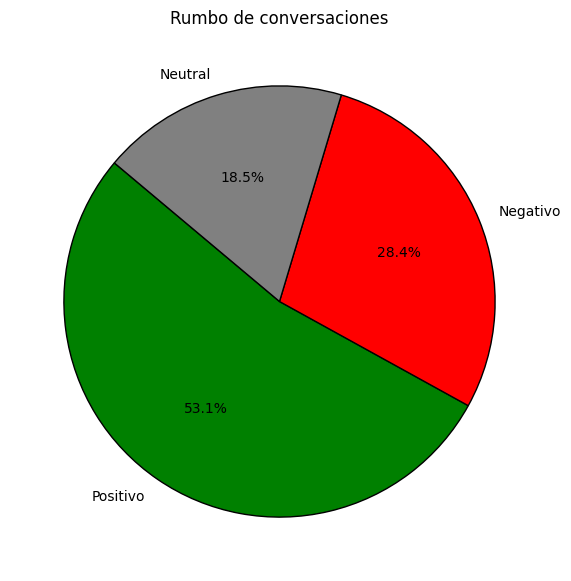

In [84]:
# Definir colores para cada sentimiento
colores = {
    "Positivo": "green",
    "Negativo": "red",
    "Neutral": "gray"
}

# Crear gráfico de pastel
plt.figure(figsize=(7,7))
plt.pie(
    porcentaje_sentimientos, 
    labels=porcentaje_sentimientos.index, 
    autopct='%1.1f%%', 
    colors=[colores[label] for label in porcentaje_sentimientos.index], 
    startangle=140, 
    wedgeprops={"edgecolor": "black"}
)

# Título del gráfico
plt.title("Rumbo de conversaciones")

# Mostrar gráfico
plt.show()

In [85]:
# Formateo
print("Tiempo de respuesta promedio:",
      formatear_tiempo_en_horas_minutos(tiempo_promedio))
print("Tiempo mensual consumido por falta de apoyo:",
      f"{round((tiempo_total/43800)*100, 2)}%")
print("Puntaje promedio:", round(puntaje_promedio, 2))

Tiempo de respuesta promedio: 1h:1m
Tiempo mensual consumido por falta de apoyo: 11.41%
Puntaje promedio: 63.46
